# Assigment 3
### 188.413 Self-Organizing Systems


Topic D: label SOM 1

  Rainer David, 51850574
	de Lambertye Grégoire, 12202211
	Gugleta Marko, 12016483

The aim of this assignment is to  print the names of the n attributes per unit/cluster that show the lowest variance and/or the highest mean values within a specific unit or cluster, as text on the map units / clusters

In [1]:
import numpy as np
import pandas as pdcoding
import gzip

# SOM training  

We used the 2 datasets *Chainlink* and *10-Clusters* and trained 2 SOMs.
One SOM (small) is 10x10 and trained on the 10-Clusters dataset for 10'000 iterations. The second SOM is 100x60 and trained for 100'000 iteration on the Chainlink dataset

In [10]:
#SOMToolbox Parser
from pysomvis import PySOMVis
from SOMToolBox_Parse import SOMToolBox_Parse
from minisom import MiniSom
idata_10cluster = SOMToolBox_Parse("datasets/10clusters/10clusters.vec").read_weight_file()

som_10cluster_small = MiniSom(10, 10, idata_10cluster['vec_dim'])
som_10cluster_small.train(idata_10cluster['arr'], 10000)

weights_small_10cluster = som_10cluster_small._weights

vis = PySOMVis(weights=weights_small_10cluster, input_data=idata_10cluster['arr'], )
vis._mainview

BokehModel(combine_events=True, render_bundle={'docs_json': {'340b0b93-f954-4b7d-ab91-00f1a915dbaa': {'version…

In [24]:
idata_chainlink = SOMToolBox_Parse("datasets/chainlink/chainlink.vec").read_weight_file()

som_chainlink_big = MiniSom(100, 60, idata_chainlink['vec_dim'])
som_chainlink_big.train(idata_chainlink['arr'], 100000)

weights_big_chainlink = som_chainlink_big._weights
weights_big_chainlink.flatten()

vis = PySOMVis(weights=weights_big_chainlink, input_data=idata_chainlink['arr'], )
vis._mainview

BokehModel(combine_events=True, render_bundle={'docs_json': {'56505538-81cb-43c7-a33f-0198f93709d1': {'version…

In [32]:
weights_big_chainlink = weights_big_chainlink.flatten().shape
# weights_big_chainlink.shape

(18000,)

## Clustering

The aim of this section is to get together similar units into cluser

In [26]:
from bokeh.plotting import show

def plot_clusters(predicted_clusters, name="Cluster", add_text=None, labels=None):
    """
    Get in input a mxn array with the cluster label as value and plot the representation
    """
    cluster = hv.Image(predicted_clusters).opts(xaxis=None, yaxis=None)
    if add_text == "Cluster":
        cluster_indexes = find_center_clusters(predicted_clusters)
        cluster = add_text_clusters(cluster_indexes, cluster, labels)
    elif add_text == "Unit":
        cluster = add_text_units(predicted_clusters.shape, cluster, labels)
    show(hv.render(hv.Layout([cluster.relabel(name)])))

### KMeans

In [27]:
from sklearn.cluster import KMeans

def find_clusters_KMeans(data, k_clusters=3):
    """
    Retunr a KMeans object fitted on the given data for a defined amount of clusters
    """
    km_classifier = KMeans(n_clusters=k_clusters, random_state=42)
    initial_labels = km_classifier.fit_predict(data)
    km_classifier.fit(data, initial_labels)

    return km_classifier

In [28]:
import warnings

warnings.filterwarnings("ignore")

# Get the cluster for each units
km_classifier = find_clusters_KMeans(weights_small_10cluster, k_clusters=10)

kMean_clusters = km_classifier.predict(weights_small_10cluster)

# km_classifier = find_clusters_KMeans(weights_big_chainlink, k_clusters=3)

# kMean_clusters = km_classifier.predict(weights_big_chainlink)

ValueError: Found array with dim 3. KMeans expected <= 2.

### Hierarchical clustering

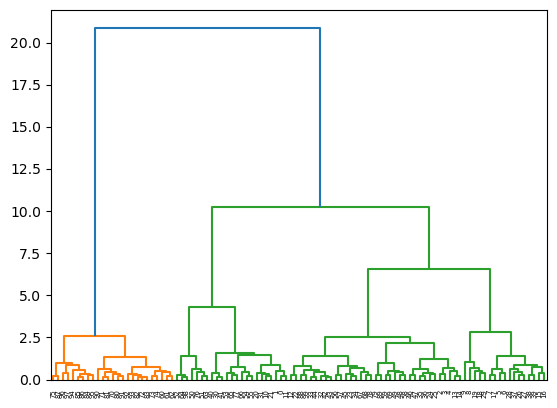

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt

# Compute the hierarchical proximity
linkage_data = linkage(weights['arr'], method='ward', metric='euclidean')
dendrogram(linkage_data)
plt.show()

## Extracting High Mean Low Variance Attributes

### Various helper functions

In [ ]:
def normalize_data(data):
    """
    Performs zero mean unit variance normalization on the given datapoints.
    Allows inter attribute comparison.

    :param data: The np array containting the data points
    :return: an np array containing normalized datapoints
    """
    normalized_data = np.copy(data)
    means = np.mean(data, axis=0)
    std_diviations = np.std(data, axis=0)
    dimensions = data.shape[1]
    for i in range(0, dimensions):
        normalized_data[:, i] = normalized_data[:, i] - means[i]
        normalized_data[:, i] = normalized_data[:, i] / std_diviations[i]
    return normalized_data

In [ ]:
def assign_bmus(data, units):
    """
    Assigns each datapoint to its best matching unit.

    :param data: np array of datapoints
    :param units: np array containg the weight vectors for all units
    :return: a list containing an entry per SOM unit with the indexes of all datapoints for which the unit is the BMU
    """
    # Init assignment list
    bmu_assignments = []
    for i in range(0, units.shape[0]):
        bmu_assignments.append([])

    # Add index to closest unit's list
    for idx, data_point in enumerate(data):
        dists = np.linalg.norm(units - data_point, axis = 1)
        min_idx = np.argmin(dists)
        bmu_assignments[min_idx].append(idx)
        
    return bmu_assignments

In [ ]:
def get_means(points):
    if len(points) == 0:
        return None
    elif len(points) == 1:
        return points[0]
    else:
        return np.mean(np.array(points), axis=0)

def get_standard_deviations(points):
    if len(points) == 0:
        return None
    elif len(points) == 1:
        return np.zeros_like(points[0])
    else:
        return np.std(np.array(points), axis=0)

# Avoid division by 0 for fully homogenous attributes
MIN_VARIANCE = 0.0000001

def replace_with_min_variance(array):
    res = []
    for i in array:
        if i < MIN_VARIANCE:
            res.append(MIN_VARIANCE)
        else:
            res.append(i)
    return np.array(res)

def flatten(xss):
    return [x for xs in xss for x in xs]

### Per Unit

In [ ]:
def get_high_mean_low_variance_attributes_per_unit(
    data,
    units,
    num_attributes,
    mean_factor,
    variance_factor,
):
    """
    Assigns each unit the specified number of high mean low variance attributes.
    Attributes are given as dimension ids.
    Name mapping needs to happen saparately.
    Interpolating unit without Data are assigned an empty array.

    :param data: the unnormalized datapoints
    :param units: the unnormalized weight vectors of the SOM units
    :param num_attributes: the max number of attributes returned for each unit
    :param mean_factor: controls impact of mean on attribute score
    :param variance_factor: controls impact of variance on attribute score
    :return: a list of attribute assignments per unit
    """
    if data.shape[1] != units.shape[1]:
        raise Exception("your datapoints and SOM units are not of the same dimension")
        
    bmu_assignments = assign_bmus(data, units)
    
    norm_data = normalize_data(data)
    normalized_assignments = [[norm_data[p] for p in a] for a in bmu_assignments]
    
    means = [get_means(a) for a in normalized_assignments]
    std_divs = [get_standard_deviations(a) for a in normalized_assignments]

    attrs = []
    for i in range(0, units.shape[0]):
        unit_means = means[i]
        unit_std_divs = std_divs[i]

        if unit_means is None or unit_std_divs is None:
            # interpolating unit -> do not label
            attrs.append(np.array([]))
            continue

        # TODO is this the smartest way to calculate this? 
        scores = (unit_means * mean_factor) + ((1.0 / replace_with_min_variance(unit_std_divs)) * variance_factor)
        
        attributes_to_take = num_attributes if num_attributes <= scores.shape[0] else scores.shape[0]
        min_attrs = np.argpartition(scores, attributes_to_take)
        attrs.append(min_attrs[:attributes_to_take])
    
    return attrs

In [ ]:
def get_high_mean_attributes_per_unit(
    data,
    units,
    num_attributes,
):
    """
    Assigns each unit the specified number of high mean attributes.
    Attributes are given as dimension ids.
    Name mapping needs to happen saparately.
    Interpolating unit without Data are assigned an empty array.

    :param data: the unnormalized datapoints
    :param units: the unnormalized weight vectors of the SOM units
    :param num_attributes: the max number of attributes returned for each unit
    :return: a list of attribute assignments per unit
    """
    return get_high_mean_low_variance_attributes_per_unit(data, units, num_attributes, 1, 0)

def get_low_variance_attributes_per_unit(
    data,
    units,
    num_attributes,
):
    """
    Assigns each unit the specified number of low variance attributes.
    Attributes are given as dimension ids.
    Name mapping needs to happen saparately.
    Interpolating unit without Data are assigned an empty array.

    :param data: the unnormalized datapoints
    :param units: the unnormalized weight vectors of the SOM units
    :param num_attributes: the max number of attributes returned for each unit
    :return: a list of attribute assignments per unit
    """
    return get_high_mean_low_variance_attributes_per_unit(data, units, num_attributes, 0, 1)

### Per Cluster

In [ ]:
def match_cluster_id(predicted_clusters):
    """
    Transform the cluster predictions into a dictionary (cluster_id: unit_id)
    """
    clusters = {}
    for id, cluster_id in enumerate(predicted_clusters):
        if cluster_id not in clusters.keys():
            clusters[cluster_id] = []
        clusters[cluster_id].append(id)
        
    return clusters    

In [ ]:
def get_high_mean_low_variance_attributes_per_cluster(
    data,
    units,
    cluster_partition,
    num_attributes,
    mean_factor,
    variance_factor,
):
    """
    Assigns each cluster the specified number of high mean low variance attributes.
    Attributes are given as dimension ids.
    Name mapping needs to happen saparately.
    Clusters are given as a list with the same number of elements as there are units in the SOM
    Interpolating unit without Data are assigned an empty array.

    :param data: the unnormalized datapoints
    :param units: the unnormalized weight vectors of the SOM units
    :param cluster_partition: a list of cluster assignments for each unit of the SOM
    :param num_attributes: the max number of attributes returned for each unit
    :param mean_factor: controls impact of mean on attribute score
    :param variance_factor: controls impact of variance on attribute score
    :return: a dictionary where key = cluster id and the value is the list of extracted attributes
    """
    if data.shape[1] != units.shape[1]:
        raise Exception("your datapoints and SOM units are not of the same dimension")
        
    bmu_assignments = assign_bmus(data, units)
    norm_data = normalize_data(data)
    
    res = {}
    cluster_partition = match_cluster_id(cluster_partition)
    for cluster_id , cluster in cluster_partition.items():      
        bmu_cluster_assignments = flatten([bmu_assignments[unit_id] for unit_id in cluster])
        normalized_assignments = [norm_data[p] for p in bmu_cluster_assignments]
        
        means = get_means(normalized_assignments)
        std_divs = get_standard_deviations(normalized_assignments)
    
        if means is None or std_divs is None:
            # Unlikely case of cluster of only interpolating units
            res.append(np.array([]))
            continue
    
        scores = (means * mean_factor) + ((1.0 / replace_with_min_variance(std_divs)) * variance_factor)
            
        attributes_to_take = num_attributes if num_attributes <= scores.shape[0] else scores.shape[0]
        min_attrs = np.argpartition(scores, attributes_to_take)
        res[cluster_id] = min_attrs[:attributes_to_take]
        
    return res

In [ ]:
def get_high_mean_attributes_per_cluster(
    data,
    units,
    cluster_partition,
    num_attributes,
):
    """
    Assigns each cluster the specified number of high mean attributes.
    Attributes are given as dimension ids.
    Name mapping needs to happen saparately.
    Clusters are given as a list with the same number of elements as there are units in the SOM
    Interpolating unit without Data are assigned an empty array.

    :param data: the unnormalized datapoints
    :param units: the unnormalized weight vectors of the SOM units
    :param cluster_partition: a list of cluster assignments for each unit of the SOM
    :param num_attributes: the max number of attributes returned for each unit
    :return: a dictionary where key = cluster id and the value is the list of extracted attributes
    """
    return get_high_mean_low_variance_attributes_per_unit(data, units, num_attributes, 1, 0)

def get_low_variance_attributes_per_cluster(
    data,
    units,
    cluster_partition,
    num_attributes,
):
    """
    Assigns each cluster the specified number of low variance attributes.
    Attributes are given as dimension ids.
    Name mapping needs to happen saparately.
    Clusters are given as a list with the same number of elements as there are units in the SOM
    Interpolating unit without Data are assigned an empty array.

    :param data: the unnormalized datapoints
    :param units: the unnormalized weight vectors of the SOM units
    :param cluster_partition: a list of cluster assignments for each unit of the SOM
    :param num_attributes: the max number of attributes returned for each unit
    :return: a dictionary where key = cluster id and the value is the list of extracted attributes
    """
    return get_high_mean_low_variance_attributes_per_unit(data, units, num_attributes, 0, 1)

In [ ]:
# Example of how to use the attribute extraction functions
attr_mappings = get_high_mean_low_variance_attributes_per_unit(idata["arr"],weights["arr"], 2, 1, 1)

# TODO we should load these form the provided files instead of hardcoding
attr_names = ["sep_length", "sep_width", "pet_length", "pet_width"]

print("per unit:")
named_mappings = [np.array([attr_names[id] for id in mapping]) for mapping in attr_mappings]
print(named_mappings)

print("per cluster:")
cluster_attr_mappings = get_high_mean_low_variance_attributes_per_cluster(idata["arr"],weights["arr"], kMean_clusters, 2, 0, 1)
named_cluster_mappings = {cluster_id:np.array([attr_names[id] for id in mapping]) for (cluster_id, mapping) in cluster_attr_mappings.items()}
print(named_cluster_mappings)

per unit:
[array([], dtype=float64), array(['sep_width', 'sep_length'], dtype='<U10'), array([], dtype=float64), array(['sep_width', 'sep_length'], dtype='<U10'), array(['sep_width', 'sep_length'], dtype='<U10'), array(['sep_width', 'sep_length'], dtype='<U10'), array(['sep_width', 'pet_length'], dtype='<U10'), array(['sep_width', 'pet_width'], dtype='<U9'), array(['sep_width', 'pet_length'], dtype='<U10'), array(['sep_width', 'pet_width'], dtype='<U9'), array(['sep_width', 'sep_length'], dtype='<U10'), array(['sep_width', 'sep_length'], dtype='<U10'), array([], dtype=float64), array(['sep_width', 'sep_length'], dtype='<U10'), array(['sep_length', 'pet_length'], dtype='<U10'), array(['sep_width', 'pet_length'], dtype='<U10'), array(['sep_width', 'pet_width'], dtype='<U9'), array(['sep_length', 'pet_length'], dtype='<U10'), array(['sep_width', 'pet_width'], dtype='<U9'), array(['pet_width', 'sep_width'], dtype='<U9'), array(['sep_width', 'pet_width'], dtype='<U9'), array([], dtype=float

## Visualization of the Labeling 

Appending the text on top of visualized maps.

In [13]:
def add_text(img1, img2):
  """
  Function used for combining two images

  img1: image to be combined (usually SOM)
  img2: image to be combined (usually text)
  return: combined image
  """
  return ((img1 * img2).opts(
            opts.Image(cmap='viridis'),
            opts.Text(color='black', text_font_size='5pt')
        ))

def find_center_clusters(input_array, name="Cluster"):
    """
    Get in input a mxn array with the cluster label as value and return the center of each cluster
    """
    def find_cluster_middle(cluster):
        rows, cols = zip(*cluster)
        middle_row = np.median(rows).astype(int)
        middle_col = np.median(cols).astype(int)
        return middle_row, middle_col

    cluster_indexes = []
    visited = set()

    for i in range(input_array.shape[0]):
        for j in range(input_array.shape[1]):
            if input_array[i, j] not in visited:
                cluster = [(x, y) for x in range(input_array.shape[0]) for y in range(input_array.shape[1]) if input_array[x, y] == input_array[i, j]]
                cluster_indexes.append((input_array[i, j], find_cluster_middle(cluster)))
                visited.update(cluster)

    cluster_indexes = set(cluster_indexes)
    return cluster_indexes

def transform_coords(x, y):
    """
    Transform the coordinates from the range [0, 10] to [-0.5, 0.5] to match the hv.Image coordinates
    """
    min_ = 0
    max_ = 10
    magnifier = -0.5
    l = magnifier + (x - min_) / (max_ - min_)
    r = magnifier + (y - min_) / (max_ - min_)
    return l, r

def add_text_clusters(cluster_indexes, img1, labels):
    """
    Add the cluster label to the center of each cluster
    """
    for num, index in cluster_indexes:
        c = 0
        for name in labels[num]:
            l, r = transform_coords(index[1], index[0])
            r = (-1 * r) - c
            c += 0.03
            img1 = add_text(img1, hv.Text(l, r, name))

    return img1

def add_text_units(shape, img, labels):
    """
    Add the label to each unit
    """
    start_x = -0.45
    start_y = 0.46
    x = start_x
    y = start_y
    for i in range(shape[0]):
        x = start_x
        for j in range(shape[1]):
            label = labels[i*10+j]
            temp_y = y
            for l in label:
                img = add_text(img, hv.Text(x, temp_y, l))
                temp_y += 0.03
            x += 0.1
        y -= 0.1
    return img

In [ ]:
plot_clusters(kMean_clusters.reshape(weights['ydim'], weights['ydim']), 'KMean clusters', add_text="Cluster", labels=named_cluster_mappings)
plot_clusters(kMean_clusters.reshape(weights['ydim'], weights['ydim']), 'KMean clusters', add_text="Unit", labels=named_mappings)